In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import time
import gc
import copy
import sys
import os
from pylab import *
import copy
from scipy.stats import pearsonr

In [ ]:
def preprocess(data):
    zeros = np.zeros_like(data)
    mean = np.mean(data, axis = 0)
    std = np.std(data, axis = 0)
   
    std[std == 0] = 1  # Avoid division by zero by setting std to 1 where it is 0
    zeros = (data - mean) / std
    return zeros


In [3]:
run_time = time.time()
file_numbers = [1, 2, 4, 8, 14, 15, 20, 23]

classes_left = np.arange(0, 20)
classes_right = np.arange(0, 20)

agg_structure = {cl: 
                  {cr: [] for cr in classes_right} for cl in classes_left} 


l_al_data = copy.deepcopy(agg_structure)
r_al_data = copy.deepcopy(agg_structure)
a_al_data = copy.deepcopy(agg_structure)

l_ar_data = copy.deepcopy(agg_structure)
r_ar_data = copy.deepcopy(agg_structure)
a_ar_data = copy.deepcopy(agg_structure)


n_values = {cl:
             {cr: {
                'attleft': [],
                'attright': []
                } for cr in classes_right} for cl in classes_left} 

#loading the data by class combinations

for file_number in file_numbers:   #will first load the file and extract the data
    file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
    data = pickle.load(open(file_path, 'rb'))

    attention_labels = data['label_attend'][0]
    label_left = data['label_left'][0]
    label_right = data['label_right'][0]
    attend_01 = data['attend'][0]
    omitted = data["omit"][0]
    relevant = np.where(omitted == 0)[0]    #indices of agg where not omitted

    left_input_LFP = preprocess(data['LFP'][0][0][relevant])
    right_input_LFP = preprocess(data['LFP'][0][1][relevant])
    attention_LFP = preprocess(data['LFP_rec'][0][2][relevant])

    for cl in classes_left:
        for cr in classes_right: 
    
            left_indices_agg = np.where((omitted ==0) & (attend_01 == 0) & (label_left == cl) & (label_right == cr))[0]
            left_indices = np.where(np.isin(relevant, left_indices_agg))[0]
            right_indices_agg = np.where((omitted ==0) & (attend_01 == 1) & (label_left == cl) & (label_right == cr))[0]
            right_indices = np.where(np.isin(relevant, right_indices_agg))[0]
       
            n_values[cl][cr][f'attleft'] = [len(left_indices)]  #e.g. checks number of trials of this class combo for attentino left
            n_values[cl][cr][f'attright'] = [len(right_indices)]  #nb need both left and right indices to be non empty

            if len(left_indices) >= 1:
                l_al = left_input_LFP[left_indices][:, 100:350]
                r_al = right_input_LFP[left_indices][:, 100:350]
                a_al = attention_LFP[left_indices][:, 100:350]

                l_al_data[cl][cr].append(l_al)
                r_al_data[cl][cr].append(r_al)
                a_al_data[cl][cr].append(a_al)

            if len(right_indices) >= 1:

                l_ar = left_input_LFP[right_indices][:, 100:350]
                r_ar = right_input_LFP[right_indices][:, 100:350]
                a_ar = attention_LFP[right_indices][:, 100:350]

                l_ar_data[cl][cr].append(l_ar)   
                r_ar_data[cl][cr].append(r_ar)
                a_ar_data[cl][cr].append(a_ar)

            if cl == 1 and cr == 1:
                print('found a 11')
                print(left_indices)

          

    del data
    gc.collect()



found a 11
[431 548]
found a 11
[251]
found a 11
[]
found a 11
[490]
found a 11
[]
found a 11
[ 37 525 598]
found a 11
[248]
found a 11
[146 695 860 981]


In [4]:
for cl in classes_left:
    for cr in classes_right:
        if len(l_al_data[cl][cr]) > 0:
            l_al_data[cl][cr] = np.concatenate(l_al_data[cl][cr], axis = 0)
            r_al_data[cl][cr] = np.concatenate(r_al_data[cl][cr], axis = 0)
            a_al_data[cl][cr] = np.concatenate(a_al_data[cl][cr], axis = 0)

            l_ar_data[cl][cr] = np.concatenate(l_ar_data[cl][cr], axis = 0)
            r_ar_data[cl][cr] = np.concatenate(r_ar_data[cl][cr], axis = 0)
            a_ar_data[cl][cr] = np.concatenate(a_ar_data[cl][cr], axis = 0)
            

        else:
            print(f"No data for class left {cl} and class right {cr}.")


##-----------------calculating the number of trials for each class pair----------------
n_values_sum = {cl: {cr: {'attleft': 0, 'attright': 0} for cr in classes_right} for cl in classes_left}


for cl in classes_left:
    for cr in classes_right:
        n_values_sum[cl][cr]['attleft'] = len(l_al_data[cl][cr]) 
        n_values_sum[cl][cr]['attright'] = len(l_ar_data[cl][cr]) 
        

In [6]:
#-------------coherence calculation----------------
lr_split_structure = {cl: {cr: {
    'left_attleft': [], 'right_attleft': [], 'left_attright': [], 'right_attright': []
    } for cr in classes_right} for cl in classes_left}


pearson_values = copy.deepcopy(lr_split_structure)
pearson_stdevs = copy.deepcopy(lr_split_structure)

run_time = time.time()
for cl in classes_left:
    coh_start = time.time()
    for cr in classes_right: 

        if n_values_sum[cl][cr]['attleft'] == 0:  ##this makes sure you only calulate for left class pairs that have trials
            continue                    
        
        for i in range(len(l_al_data[cl][cr])):
            pearson_values[cl][cr]['left_attleft'].append(pearsonr(l_al_data[cl][cr][i], a_al_data[cl][cr][i])[0])
            pearson_values[cl][cr]['right_attleft'].append(pearsonr(r_al_data[cl][cr][i], a_al_data[cl][cr][i])[0])

    

for cl in classes_left:
    for cr in classes_right: 
        if n_values_sum[cl][cr]['attright'] == 0:  #right class pairs that have trials
            print(f"[SKIP] {cl}-{cr}: no attleft trials")
            continue    

        for i in range(len(l_ar_data[cl][cr])):
            pearson_values[cl][cr]['left_attright'].append(pearsonr(l_ar_data[cl][cr][i], a_ar_data[cl][cr][i])[0])
            pearson_values[cl][cr]['right_attright'].append(pearsonr(r_ar_data[cl][cr][i], a_ar_data[cl][cr][i])[0])    

    print(f"Class pair {cl} {cr} processed in {time.time() - coh_start:.2f} seconds")
         
run_time = time.time() - run_time
print(f"Total run time: {run_time:.2f} seconds")


Class pair 0 19 processed in 0.17 seconds
Class pair 1 19 processed in 0.25 seconds
Class pair 2 19 processed in 0.35 seconds
Class pair 3 19 processed in 0.43 seconds
Class pair 4 19 processed in 0.54 seconds
Class pair 5 19 processed in 0.63 seconds
Class pair 6 19 processed in 0.74 seconds
Class pair 7 19 processed in 0.85 seconds
Class pair 8 19 processed in 0.94 seconds
Class pair 9 19 processed in 1.04 seconds
Class pair 10 19 processed in 1.14 seconds
Class pair 11 19 processed in 1.23 seconds
Class pair 12 19 processed in 1.34 seconds
Class pair 13 19 processed in 1.45 seconds
Class pair 14 19 processed in 1.54 seconds
Class pair 15 19 processed in 1.64 seconds
Class pair 16 19 processed in 1.74 seconds
Class pair 17 19 processed in 1.86 seconds
Class pair 18 19 processed in 1.95 seconds
Class pair 19 19 processed in 2.13 seconds
Total run time: 4.08 seconds


In [7]:
results_to_plot = copy.deepcopy(lr_split_structure)

for cl in classes_left:
    for cr in classes_right:
        for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']:
            results_to_plot[cl][cr][key] = np.mean(pearson_values[cl][cr][key])


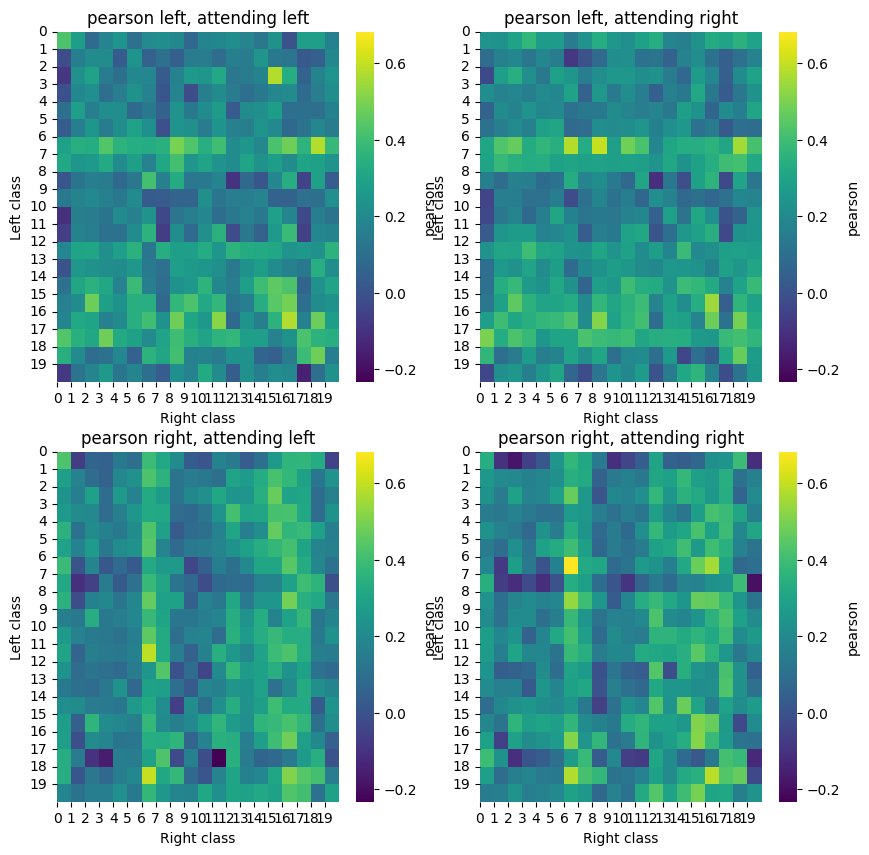

In [9]:
#==============================plotting heatmaps================================
def calculate_vmin_vmax(results_to_plot, classes_left, classes_right):
    vmax = np.max([results_to_plot[cl][cr][key] 
                   for cl in classes_left for cr in classes_right for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']])
    vmin = np.min([results_to_plot[cl][cr][key] 
                   for cl in classes_left for cr in classes_right for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']])
    return vmin, vmax


vmin, vmax = calculate_vmin_vmax(results_to_plot, classes_left, classes_right)



fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.heatmap(np.array([[results_to_plot[cl][cr]['left_attleft'] for cr in classes_right] for cl in classes_left]), ax=ax[0, 0], annot=False, fmt=".2f", cmap='viridis', cbar_kws={'label': 'pearson'}, vmin = vmin, vmax = vmax)
ax[0,0].set_xticks(np.arange(0, 20))
ax[0,0].set_yticks(np.arange(0, 20))
ax[0,0].set_xticklabels(classes_right)
ax[0,0].set_yticklabels(classes_left)
ax[0,0].set_xlabel('Right class')
ax[0,0].set_ylabel('Left class')
ax[0,0].set_title(f'pearson left, attending left')

sns.heatmap(np.array([[results_to_plot[cl][cr]['right_attleft'] for cr in classes_right] for cl in classes_left]), ax=ax[1,0], annot=False, fmt=".2f", cmap='viridis', cbar_kws={'label': 'pearson'}, vmin = vmin, vmax = vmax)
ax[1,0].set_xticks(np.arange(0, 20))
ax[1,0].set_yticks(np.arange(0, 20))
ax[1,0].set_xticklabels(classes_right)
ax[1,0].set_yticklabels(classes_left)
ax[1,0].set_xlabel('Right class')
ax[1,0].set_ylabel('Left class')
ax[1,0].set_title(f'pearson right, attending left')

sns.heatmap(np.array([[results_to_plot[cl][cr]['left_attright'] for cr in classes_right] for cl in classes_left]), ax=ax[0,1], annot=False, fmt=".2f", cmap='viridis', cbar_kws={'label': 'pearson'}, vmin = vmin, vmax = vmax)
ax[0,1].set_xticks(np.arange(0, 20))
ax[0,1].set_yticks(np.arange(0, 20))
ax[0,1].set_xticklabels(classes_right)
ax[0,1].set_yticklabels(classes_left)
ax[0,1].set_xlabel('Right class')
ax[0,1].set_ylabel('Left class')
ax[0,1].set_title(f'pearson left, attending right')

sns.heatmap(np.array([[results_to_plot[cl][cr]['right_attright'] for cr in classes_right] for cl in classes_left]), ax=ax[1,1], annot=False, fmt=".2f", cmap='viridis', cbar_kws={'label': 'pearson'}, vmin = vmin, vmax = vmax)
ax[1,1].set_xticks(np.arange(0, 20))
ax[1,1].set_yticks(np.arange(0, 20))
ax[1,1].set_xticklabels(classes_right)
ax[1,1].set_yticklabels(classes_left)
ax[1,1].set_xlabel('Right class')
ax[1,1].set_ylabel('Left class')
ax[1,1].set_title(f'pearson right, attending right')

plt.show()


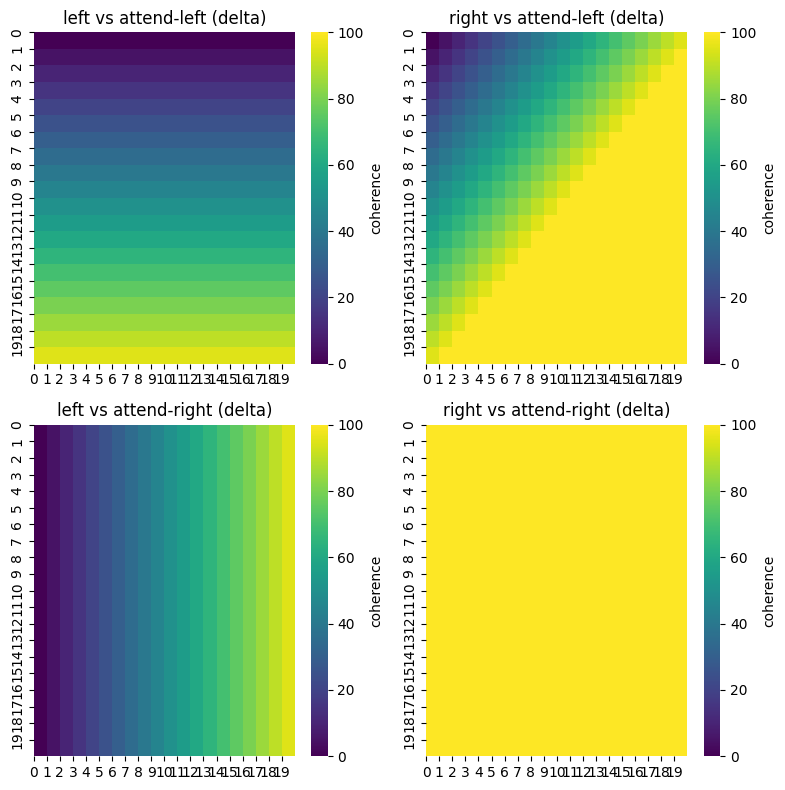

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Coerce to plain Python ints
classes_left  = [int(x) for x in classes_left]
classes_right = [int(x) for x in classes_right]

# 2) Now build the toy dict (all keys are Python ints)
toy = {
    cl: {
        cr: {
            'delta': {
                'left_attleft':   [5*cl],
                'left_attright':  [5*cr],
                'right_attleft':  [5*(cl+cr)],
                'right_attright': [100],
            }
        } for cr in classes_right
    } for cl in classes_left
}

# 3) Your plot function can stay exactly the same:
def plot_4_heat(data, band, vmin, vmax):
    nL, nR = len(classes_left), len(classes_right)
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))

    def mkmat(key):
        mat = np.full((nL, nR), np.nan)
        for i, cl in enumerate(classes_left):
            for j, cr in enumerate(classes_right):
                lst = data[cl][cr][band][key]  # cl,cr are now plain ints
                if lst:
                    mat[i, j] = lst[0]
        return mat

    keys   = ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']
    titles = [
        f'left vs attend-left ({band})',
        f'right vs attend-left ({band})',
        f'left vs attend-right ({band})',
        f'right vs attend-right ({band})',
    ]

    for ax, key, title in zip(axes.flatten(), keys, titles):
        sns.heatmap(mkmat(key), ax=ax,
                    vmin=vmin, vmax=vmax,
                    cmap='viridis',
                    cbar_kws={'label':'coherence'})
        ax.set_title(title)
        ax.set_xticks(np.arange(nR))
        ax.set_yticks(np.arange(nL))
        ax.set_xticklabels(classes_right)
        ax.set_yticklabels(classes_left)

    plt.tight_layout()
    plt.show()

# 4) Finally call it
plot_4_heat(toy, 'delta', vmin=0, vmax=100)
